# Lab 6 - Network Optimization Models - The Minimum Spanning Tree Problem

<b>Information on group members:</b><br>
1) 145464, Janek Gruszczyński <br>
2) 136633, Marek Szydłowski

In [1]:
%matplotlib inline
import csv

from math import sin, cos, sqrt, atan2, radians

import numpy as np
import matplotlib.pyplot as plt


In [2]:
R = 6373 # Aprox. Earth radius 

1.1) Get acquainted with the below "City" class definition. It has three major fields: name, city's longitude, and latitude. The coordinate's input is in the format "00°00'E/N," and it is converted to a list [degrees, minutes]. Also, these coordinates are also simply converted and stored as x and y coordinates. 

In [3]:
class City:
    def __init__(self, name, long, lat):
        self.name = name
        self.long = [float(long.split("°")[0]), float(long.split("°")[1].replace("'",'').replace("E",''))]
        self.x = self.long[0]*60 + self.long[1]
        self.lat = [float(lat.split("°")[0]), float(lat.split("°")[1].replace("'",'').replace("N",''))]  
        self.y = self.lat[0]*60 + self.lat[1]
       
    def __repr__(self):
        return str(self.name) + " " + str(self.lat) + " " + str(self.long)

1.2) The below piece of code loads cities data from the cities.csv file and creates a list of cities. 

In [4]:
cities = []

with open('cities.csv', newline='', encoding="utf-8") as csvfile:
    r = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in r:
        cities.append(City(row[0], row[1], row[2]))
        
for c in cities[:10]: ### TEST
    print(c)

Adamów (siedleckie) [51.0, 45.0] [22.0, 15.0]
Adamów (zamojskie) [50.0, 36.0] [23.0, 10.0]
Adamówka [50.0, 16.0] [22.0, 42.0]
Aleksandrów [51.0, 16.0] [19.0, 59.0]
Aleksandrów Kujawski [52.0, 53.0] [18.0, 42.0]
Aleksandrów Łódzki [51.0, 49.0] [19.0, 19.0]
Alwernia [50.0, 4.0] [19.0, 32.0]
Andrespol [51.0, 44.0] [19.0, 37.0]
Andrychów [49.0, 52.0] [19.0, 20.0]
Andrzejewo [52.0, 50.0] [22.0, 12.0]


1.3) The function below plots all cities according to their X and Y coordinates. Note that there are so many cities that Poland's boundaries can be observed. Feel free to modify the code. The unrequired input "edges" is a list of pairs of indices indicating edges to be drawn. 

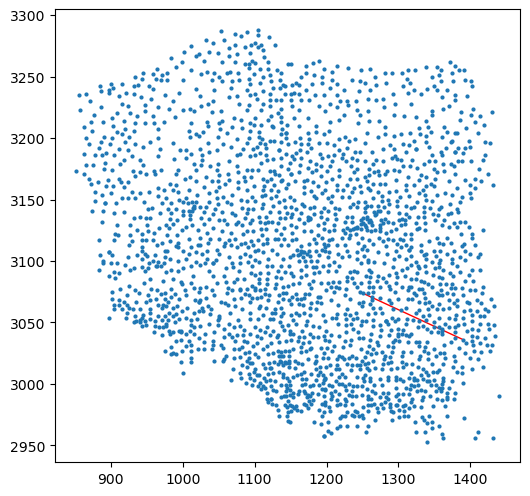

In [5]:
### TODO DEL GRADIENT
def plotMap(cities, edges=[]):
    fig=plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k')
    
    for i, e in enumerate(edges):
        color="red"
        X = [cities[e[0]].x, cities[e[1]].x]
        Y = [cities[e[0]].y, cities[e[1]].y]
        plt.plot(X, Y, lw=1, ls="-", marker="", color=color)
        
    X = [c.x for c in cities]
    Y = [c.y for c in cities]
    plt.plot(X, Y, ms=2, ls="", marker="o")
    
    plt.show()

plotMap(cities, edges=[[1,200]])

1.3) The dataset consists of 2249 cities. It may be too much when it comes to implementing the algorithm for constructing the minimum spanning tree (computational burden). Therefore, you can consider only every n-th row from the dataset to ensure that the computations will be completed in a reasonable time. 

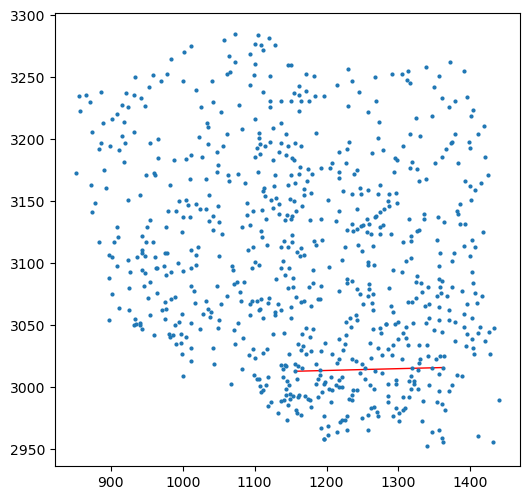

In [6]:
n = 3
cities_small = cities[2::n]
plotMap(cities_small, edges=[[0,200]])

1.4) Finish the function below for constructing a distance matrix. Each i-th row should contain distances from the i-th city to other cities. For convenience and to improve the algorithm's computational complexity for constructing the spanning tree, it is suggested to keep rows sorted according to distance. Rows may contain information on the j-th indices of the respective destinations along with the distances in a tuple (j-th indice, distance). 

You can use the Euclidean distance for computations. You can use the x and .y fields that store the geographical coordinates. This way of formulating a distance does not have much sense because the computation would be based on angles. Nonetheless, it is allowed in this exercise to do so, but if you wish, you can calculate the distances correctly by computing arc lengths between two points on a sphere - Earth. 

In [7]:
def get_radians(coords: list):
    deg, mins = coords
    return radians(deg + mins / 60)


def get_distance(city0: City, city1: City):
    """Returns distance is kms based on true distance between coordinates"""
    lat0, lon0 = get_radians(city0.lat), get_radians(city0.long)
    lat1, lon1 = get_radians(city1.lat), get_radians(city1.long)

    dlat, dlon = lat1 - lat0, lon1 - lon0

    a = sin(dlat / 2) ** 2 + cos(lat0) * cos(lat1) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c


In [8]:
cities_small[:2]

[Adamówka [50.0, 16.0] [22.0, 42.0],
 Aleksandrów Łódzki [51.0, 49.0] [19.0, 19.0]]

In [9]:
get_distance(*cities_small[:2])

292.71661547046864

In [10]:
def getDistances(cities):
    """Returns distances from city (row ind) to other cities (col inds)"""
    vec = np.vectorize(get_distance)

    out = []
    for ind in range(len(cities)):
        out.append(vec(cities[ind], cities))

    return np.array(out)

D = getDistances(cities_small)

# Fills distance to self to inf (so sorting by min. value works)
np.fill_diagonal(D, np.inf)

print(D[:2, :5])


[[         inf 292.71661547 244.43357401 398.98979008 522.07492151]
 [292.71661547          inf 216.90133212 333.55358669 241.46589992]]


1.5) Auxiliary function for finding a corresponding index in the data set for a provided city name. 

In [11]:
def getIdx(name, cities):
    for i, c in enumerate(cities):
        if name == c.name:
            return i
    return None


print(getIdx("Hel", cities_small))


178


<center> <h2> Testing start

In [12]:
visited = {178, 197}
D_cut = D[[178], :]

possible_nodes = np.dstack(np.unravel_index(np.argsort(D_cut, axis=None), D_cut.shape)).squeeze()
next_node = possible_nodes[np.isin(possible_nodes[:, 1], list(visited), invert=True), :]

In [13]:
next_node[0]

array([  0, 139])

In [14]:
_, cols = D_cut.shape
D_cut.reshape(cols,)[possible_nodes[:, 1]]

array([ 14.04801127,  18.72695342,  20.40387634,  29.69907187,
        30.11979011,  35.43846684,  37.96853155,  38.79885799,
        40.23827434,  46.95759497,  54.39589412,  61.26995676,
        63.80941778,  64.66882955,  69.78343104,  70.84725704,
        71.36984787,  72.54230227,  75.3130895 ,  76.54280542,
        77.98265271,  78.33378748,  82.31084649,  82.88157359,
        83.76657393,  83.92522273,  83.99059549,  86.7623634 ,
        92.55838748,  93.00204551,  97.23216735,  98.3113086 ,
       104.20003302, 104.57853878, 105.82422432, 109.20805933,
       111.18360768, 115.03627728, 115.46225969, 117.11496824,
       124.22572222, 125.68038291, 126.33751519, 127.47304575,
       129.0388357 , 133.78583845, 134.60934296, 135.64318588,
       135.92684838, 136.42741876, 141.09068317, 143.13984954,
       144.34031359, 144.80024584, 144.89008039, 145.99988354,
       146.7814173 , 147.34234582, 149.60474751, 150.06645234,
       150.93573096, 151.44000721, 152.13275318, 155.21

<center> <h2> Testing end


1.6) Complete the below greedy algorithm for constructing the minimum spanning tree. As an output, it should return a list of edges of the constructed subgraph, which can then be used in the plotMap function to show the tree structure. You can set the city of Hel as an initial node. 

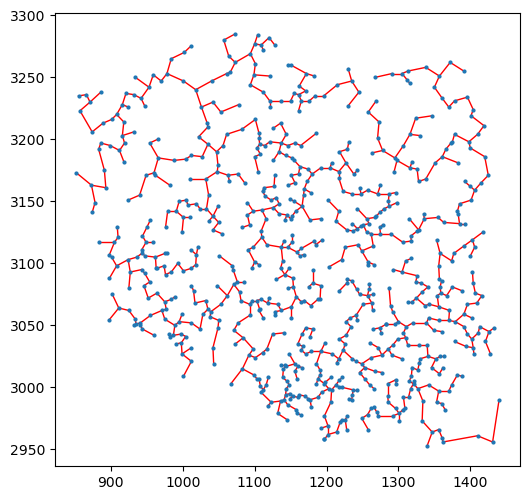

In [15]:
def getSpanningTree(stratingNode, cities, D, intermidate_steps=None):
    nodes_visited = set([stratingNode])
    edges = []

    while len(nodes_visited) != len(cities):
        ids = np.array(list(nodes_visited))
        D_cut = D[ids, :]

        # Sorts by indices, unravels the array and stacks it.
        # Items have form of: [from_node_ind, to_node] where from_node_ind 
        # is index of item in "ids" array and to_node is next_node.
        # So the final edge is looks like: ids[from_node_ind] -> to_node
        possible_nodes = np.dstack(
            np.unravel_index(np.argsort(D_cut, axis=None), D_cut.shape)
        ).squeeze()

        # Removes edges to already visited nodes
        nodes_filtered = possible_nodes[np.isin(possible_nodes[:, 1], ids, invert=True), :]

        from_node_ind, to_node = nodes_filtered[0, :]
        nodes_visited.update([to_node])
        edges.append([ids[from_node_ind], to_node])

        if intermidate_steps is not None and not (processed := len(edges)) % intermidate_steps:
            print(f"After {processed} edges:")
            plotMap(cities_small, edges=edges)

    return edges


edges = getSpanningTree(getIdx("Hel", cities_small), cities_small, D)
plotMap(cities_small, edges=edges)


1.6) Modify the code so that it displays the results after 10 intermediate steps. In this way, you can get a better insight into how the algorithm constructs the spanning tree. Additionally, you can use, e.g., a gradient to distinguish between different iterations of the algorithm when plotting the map (e.g., 1-st iteration = 100% red, last iteration == 100% green). 

After 50 edges:


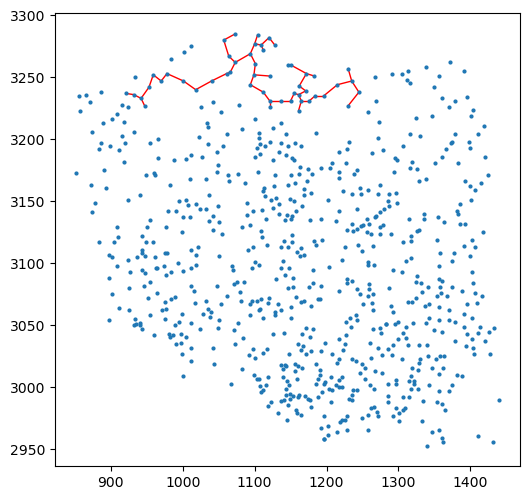

After 100 edges:


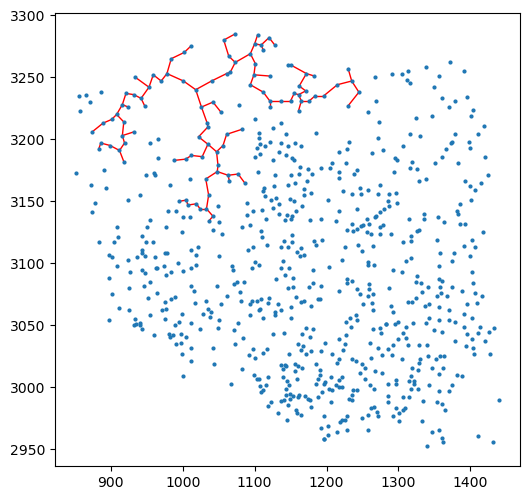

After 150 edges:


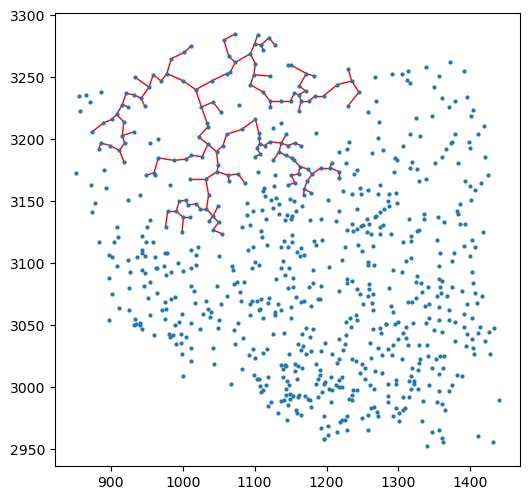

After 200 edges:


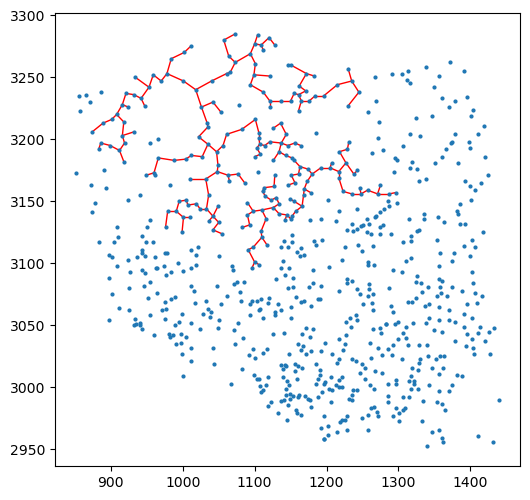

After 250 edges:


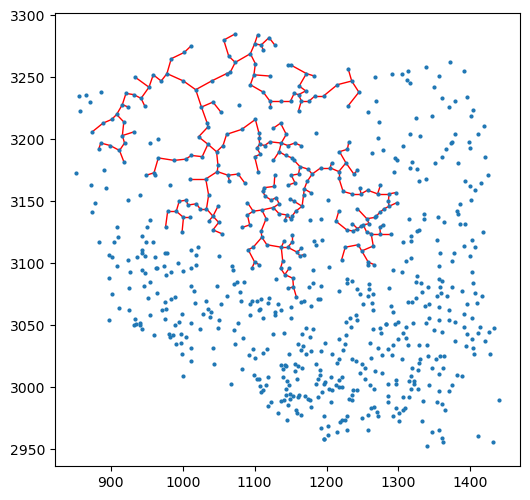

After 300 edges:


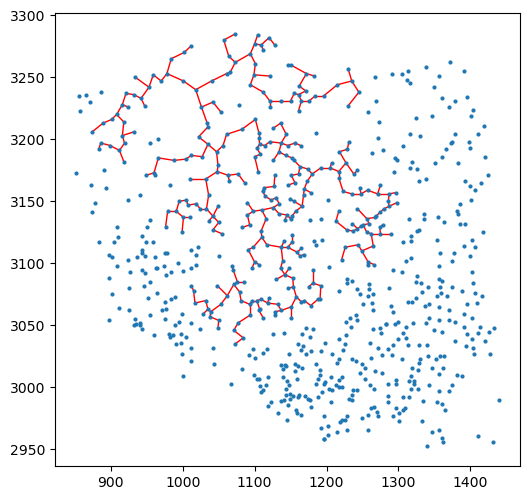

After 350 edges:


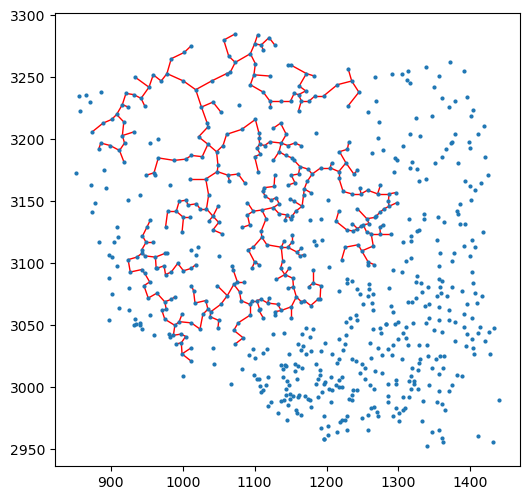

After 400 edges:


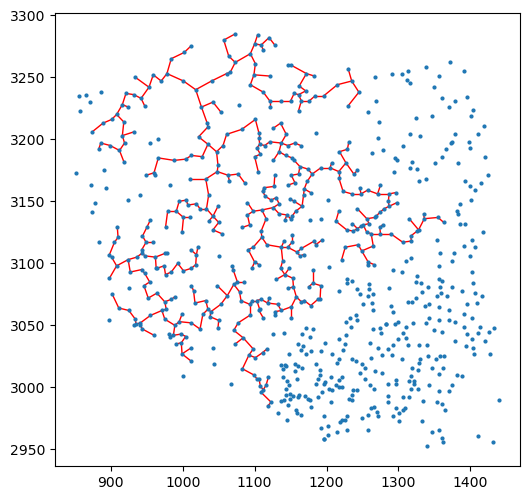

After 450 edges:


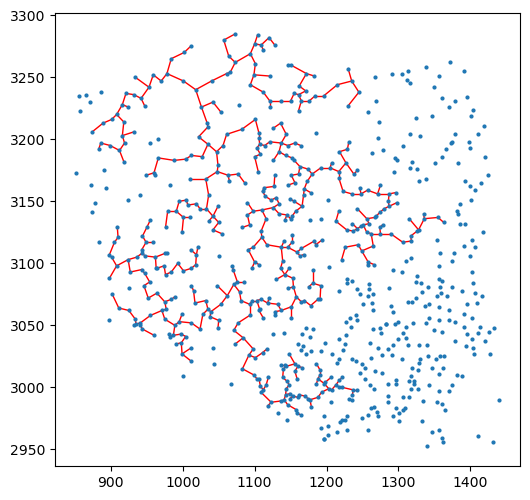

After 500 edges:


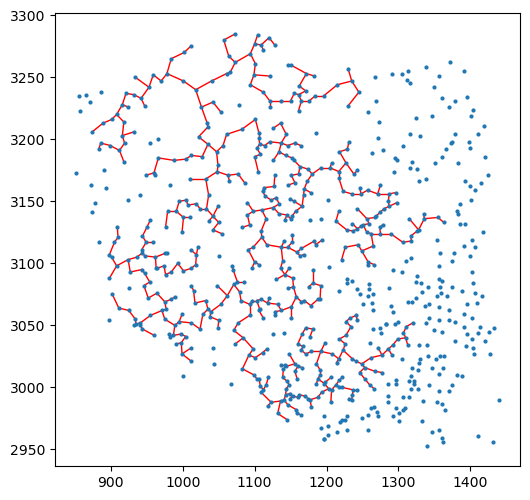

After 550 edges:


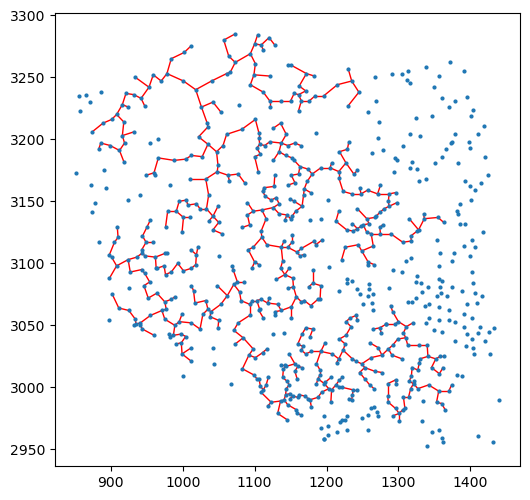

After 600 edges:


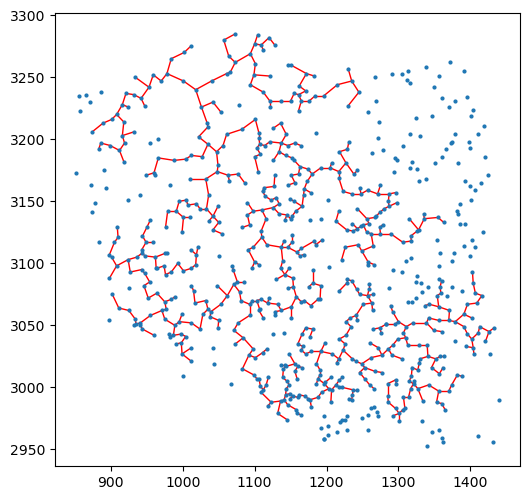

After 650 edges:


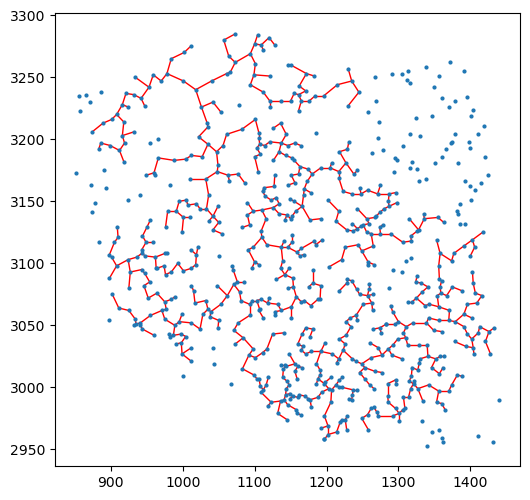

After 700 edges:


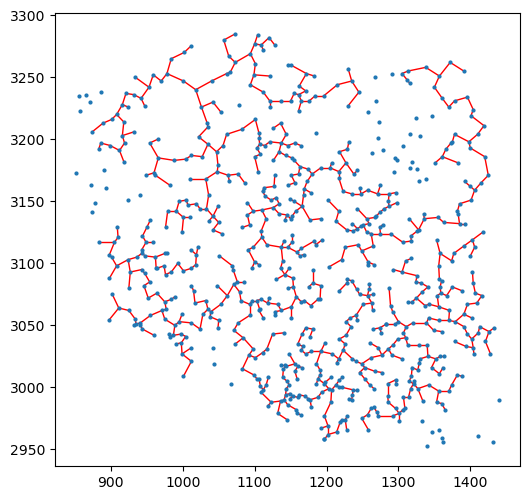

After 748 edges:


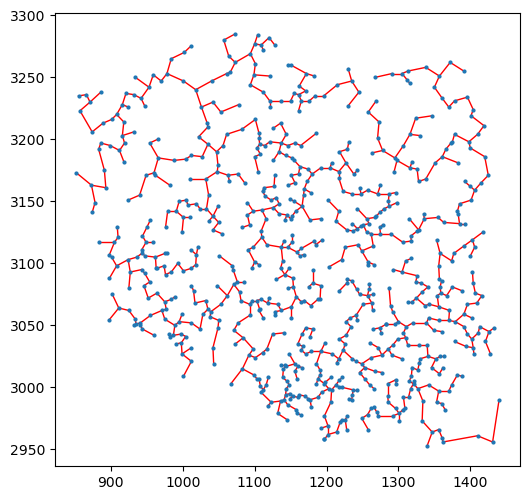

In [16]:
edges = getSpanningTree(getIdx("Hel", cities_small), cities_small, D, intermidate_steps=50)
print(f"After {len(edges)} edges:")
plotMap(cities_small, edges=edges)